In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('/home/matt/readout/host/')
import ali_offline_demod as dm
import imp
import glob
import pickle
from scipy import spatial
import h5py
from scipy.fft import fft, ifft, fftfreq
from copy import deepcopy
from scipy.interpolate import CubicSpline, interp1d
from scipy.optimize import curve_fit
from tqdm.notebook import tqdm
import imp
import pandas as pd
from scipy.signal import savgol_filter as sg

/tmp/ipykernel_845307/1643549680.py:6: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [2]:
#older demod code

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def extract_phase(t, data, n, n_blank, intermediate_plotting_limits = [None, None], plot_fft = False, plot_limited_fft = False, plot_fit = False, plot_vectors = False, plot_phase = False, verbose = False):
    """
    params
    ======
    data: data from a single flux ramp reset period
    n: number of harmonics preserved
    n_blank: number of points cut from end (to help remove flux ramp reset period)
    plot_fft: If true, plot the relevant ffts (default = False)
    plot_fit: If true, plot the relevant fit (default = False)
    """      
    #find the the two fft terms with the most power
    if intermediate_plotting_limits[0] == None:
        intermediate_plotting_limits[0] = t[0]
    if intermediate_plotting_limits[1] == None:
        intermediate_plotting_limits[1] = t[-1]
    
    data_fft = fft(data)
    freqs = fftfreq(len(data), np.median(np.diff(t)))
    
    if plot_fft == True and t[0] >= intermediate_plotting_limits[0] and t[0] <= intermediate_plotting_limits[1]:
        fig1, ax1 = plt.subplots(1)
        
        ax1.stem(freqs, np.abs(data_fft))
        ax1.set_xlabel('Frequency (Hz)')
        ax1.set_ylabel('Amplitude (arb.)')
        ax1.set_xlim([-500,500])
        ax1.set_title(f'$t_0$ = {t[0]} s')
        
    #blank the dc term
    no_dc_fft = deepcopy(data_fft)
    np.put(no_dc_fft, [0], 0.0)
    
    fundamental_idx_1 = np.argmax(np.abs(no_dc_fft))
    #print(fundamental_idx_1)
    remove_highest = deepcopy(no_dc_fft)
    #print(len(remove_highest))
    np.put(remove_highest, [fundamental_idx_1, int(len(remove_highest)-fundamental_idx_1)], 0.0) #remove the highest term and its complex conjugate in order to search for the second highest term
    fundamental_idx_2 = np.argmax(np.abs(remove_highest))
    #print(fundamental_idx_2)
    
    mask = np.zeros(len(data))
    try:
        for i in range(n):
            np.put(mask, [fundamental_idx_1*(i+1), fundamental_idx_2*(i+1)], 1.0)
            np.put(mask, [len(data)-(fundamental_idx_1*(i+1)), len(data)-(fundamental_idx_2*(i+1))], 1.0)
    except IndexError:
        print('Harmonic setting (n) too high. Using highest harmonic available.')
        
    data_fft_harmonics_only = data_fft * mask
    
    fit = ifft(data_fft_harmonics_only)
    
    if fundamental_idx_1 >= fundamental_idx_2:
        #print('1>=2')
        R1 = np.real(data_fft_harmonics_only[fundamental_idx_1])
        R2 = np.real(data_fft_harmonics_only[fundamental_idx_2])

        I1 = np.imag(data_fft_harmonics_only[fundamental_idx_1])
        I2 = np.imag(data_fft_harmonics_only[fundamental_idx_2])
        
    elif fundamental_idx_1 < fundamental_idx_2:
        #print('1<2')
        R1 = np.real(data_fft_harmonics_only[fundamental_idx_2])
        R2 = np.real(data_fft_harmonics_only[fundamental_idx_1])

        I1 = np.imag(data_fft_harmonics_only[fundamental_idx_2])
        I2 = np.imag(data_fft_harmonics_only[fundamental_idx_1])
        
    
    if I1 > 0:
        angle1 = np.angle(R1+1j*I1)
    elif I1 < 0:
        angle1 = 2*np.pi + np.angle(R1+1j*I1)
    elif I1 == 0 and R1 > 0:
        angle1 = 0
    elif I1 == 0 and R1 < 0:
        angle1 = np.pi
        
    if I2 > 0:
        angle2 = np.angle(R2+1j*I2)
    elif I2 < 0:
        angle2 = 2*np.pi + np.angle(R2+1j*I2)
    elif I2 == 0 and R2 > 0:
        angle2 = 0
    elif I2 == 0 and R2 < 0:
        angle2 = np.pi
        
    if R2 > 0 and I2 > 0 and R1 > 0 and I1 < 0: #unusual situation where vec2 is in Q1 and vec1 is in Q4: need to rotate vec2 CW (formula 2)
        interpolated_phase1 = np.arctan2((I1-R2),(R1+I2))
        formula = 2
    elif angle1 > angle2:
        interpolated_phase1 = np.arctan2((I1+R2),(R1-I2))
        formula = 1
    elif angle2 > angle1:
        interpolated_phase1 = np.arctan2((I1-R2),(R1+I2)) #something is wrong with this formula; the vector plots don't look right
        formula = 2
    
    
    #interpolated_phase1 = np.angle(data_fft_harmonics_only[fundamental_idx_1])
    #interpolated_phase2 = np.angle(data_fft_harmonics_only[fundamental_idx_2])
    #interpolated_phase1 = np.arctan2((I1+R2),(R1-I2))
    interpolated_phase2 = np.arctan2(I2,R2)
    #interpolated_phase2 = (np.arctan(I1/R1) + np.arctan(I2/R2)-np.pi/2)/2
    
    t_phase = np.median(t)
    
    
    
    if plot_limited_fft == True and t[0] >= intermediate_plotting_limits[0] and t[0] <= intermediate_plotting_limits[1]:
        fig2, ax2 = plt.subplots(1)
        
        ax2.stem(freqs, np.abs(data_fft_harmonics_only))
        ax2.set_xlabel('Frequency (Hz)')
        ax2.set_ylabel('Amplitude (arb.)')
        ax2.set_xlim([-500,500])
    
    if plot_fit == True and t[0] >= intermediate_plotting_limits[0] and t[0] <= intermediate_plotting_limits[1]:
        fig3, ax3 = plt.subplots(1)
        
        ax3.plot(t, data, '.',label='Data')
        ax3.plot(t, fit, label='fit')
        ax3.set_xlabel('t (s)')
        ax3.set_ylabel('Amplitude (arb.)')
        
    if plot_vectors == True and t[0] >= intermediate_plotting_limits[0] and t[0] <= intermediate_plotting_limits[1]:
        fig4, ax4 = plt.subplots(1)
        
        vec1 = [0+0j, data_fft_harmonics_only[fundamental_idx_1]]
        vec2 = [0+0j, data_fft_harmonics_only[fundamental_idx_2]]
        if R2 > 0 and I2 > 0 and R1 > 0 and I1 < 0: #unusual situation where vec2 is in Q1 and vec1 is in Q4: need to rotate vec2 CW (formula 2)
            vec3 = [0+0j, (R1+I2)+1j*(I1-R2)]
            label = 'angle2 > angle1; ususual Q4/Q1 case'
        elif angle1 > angle2:
            vec3 = [0+0j, (R1-I2)+1j*(R2+I1)]
            label = 'angle1 > angle2'
        elif angle2 > angle1:
            vec3 = [0+0j, (R1+I2)+1j*(I1-R2)]
            label = 'angle2 > angle1'
        
        ax4.plot(np.real(vec1), np.imag(vec1),label='vec1')
        ax4.plot(np.real(vec2), np.imag(vec2),label='vec2')
        ax4.plot(np.real(vec3), np.imag(vec3),label=label)
    
        ax4.set_xlabel('Re')
        ax4.set_ylabel('Im')
        ax4.set_xlim([-1000,1000])
        ax4.set_ylim([-1000,1000])
        ax4.legend()
    
    if plot_phase == True and t[0] >= intermediate_plotting_limits[0] and t[0] <= intermediate_plotting_limits[1]:
        fig5, ax5 = plt.subplots(1)
        
        data_fft_phase_threshold = deepcopy(data_fft_harmonics_only)
        threshold = max(np.abs(data_fft_phase_threshold))/10000
        data_fft_phase_threshold[np.abs(data_fft_phase_threshold) < threshold] = 0.0
        
        ax5.stem(freqs,np.angle(data_fft_phase_threshold))
        
    if verbose == True:
        print(f'Angle 1: {angle1} Angle 2: {angle2} Formula: {formula}')
        
    
    return freqs, data_fft_harmonics_only, t, fit, t_phase, interpolated_phase1, interpolated_phase2

def demodulate(t,sig,channels,chunks,n_zeroed,f_fr,time_method='original',phase_units='rad',correct_accumulated_phase=False,use_sg_filter=False,sg_degree=3,plot_demod = False,plot_demod_title=None,intermediate_plotting_limits=[None,None],plot_chunking_process = False,plot_fft = False,plot_limited_fft = False,plot_fit = False,plot_vectors = False,plot_phase = False,save_individual=False,save_path='/home/matt/Documents',save_note='demod_plot',verbose = False):
    """
    time_method: if 'original' chunking maintains true time, if 'zeroed' chuning zeros each chunk
    """
    
    if plot_demod == True:
        fig_demod, ax_demod = plt.subplots(1)
    
    count=0
    for ch in tqdm(channels):
        #establish array for storing phase
        phase_array = np.array([])
        
        if plot_chunking_process == True:
            #print(sig[ch])
            fig1, ax1 = plt.subplots(1)
            ax1.plot(t,sig[ch],'.-')

        #interpolate the data
        interpolation = interp1d(test_ts_processed['fr t'], test_ts_processed['fr data'][ch])

        t_final = t[-1]
        t_start = t[0]
        t_elapsed = t_final - t_start
        n_reset_periods = t_elapsed * f_fr

        t_interp = np.linspace(t_start, t_final, int(n_reset_periods)*1024)
        sig_interp = interpolation(t_interp)
        
        if plot_chunking_process == True:
            fig2, ax2 = plt.subplots(1)
            ax2.plot(t_interp, sig_interp,'.')

            
            fig3, ax3 = plt.subplots(1)
            fig4, ax4 = plt.subplots(1)    
            fig5, ax5 = plt.subplots(1)

        chunk_start_idx = find_nearest_idx(t_interp, test_ts_processed['fr t'][test_ts_processed['start index']])
        n_fr = f_fr*(t_interp[-1] - t_interp[chunk_start_idx])
        n_ptsfr = len(t_interp[chunk_start_idx:]) / n_fr

        chunk_count = 0
        for chunk in chunks:          
            
            #chunk the interpolated data
            channel_start_idx = find_nearest_idx(t_interp, t[test_ts_processed['start index']]) #+10
            #chunk_stop_idx = find_nearest_idx(t_interp, t[test_ts_processed['reset indices'][chunk+1]])

            idx_increase = round(n_ptsfr)

            start = channel_start_idx + idx_increase*chunk
            stop = channel_start_idx + idx_increase*(chunk + 1)
            
            average = np.average(sig_interp)
            
            t_chunk = t_interp[start:stop] 
            if time_method == 'zeroed':
                t_chunk -= t_interp[start]

            sig_chunk = sig_interp[start:stop]-average
            #print(f'len t_chunk: {len(t_chunk)}')
            

            if plot_chunking_process == True:
                ax3.plot(t_chunk, sig_chunk,'.',alpha = 0.5)

            #set points that are part of fr reset period to zero        
            endpoint_idx = find_nearest_idx(t_chunk,t[test_ts_processed['reset indices'][chunk+1]-n_zeroed]+t[test_ts_processed['start index']]) #figure out the time stamp in the interpolation that is closest to the blanking point in the original data
            #n_points_no_interp = (t[-1]-t[0])*f_fr
            #idx_increase_no_interp = int(n_points_no_interp)
            #print(f'len t_chunk: {len(t_chunk)}')
            #print(f'endpoint idx no interp: {t[test_ts_processed["start index"]] + idx_increase_no_interp*(chunk+1) - n_zeroed}')
            #endpoint_idx = find_nearest_idx(t_chunk,t[test_ts_processed['start index']] + idx_increase_no_interp*(chunk+1) - n_zeroed)
            #print(f'endpoint idx: {endpoint_idx}')
            sig_chunk[endpoint_idx:] = 0

            if plot_chunking_process == True:
                ax4.plot(t_chunk, sig_chunk, '.')

            sig_zero_pad = np.append(sig_chunk, np.zeros(len(sig_chunk)))
            diff = np.median(np.diff(t_chunk))
            t_zero_pad = np.append(t_chunk, np.linspace(t_chunk[-1]+diff, (t_chunk[-1]+diff) + (t_chunk[-1] - t_chunk[0]), len(t_chunk)))
            #np.linspace(t_chunk[0], t_chunk[-1] + (t_chunk[-1] - t_chunk[0]), 2*len(t_chunk))

            if plot_chunking_process == True:
                ax5.plot(t_zero_pad, sig_zero_pad, '.',alpha=0.5)




            
            freqs, data_fft_harmonics_only, t_fit, fit, t_phase, phase1, phase2 = extract_phase(t=t_zero_pad, 
                                                                                                data=sig_zero_pad, 
                                                                                                n=1, 
                                                                                                n_blank=0, 
                                                                                                intermediate_plotting_limits = intermediate_plotting_limits,
                                                                                                plot_fft = plot_fft, 
                                                                                                plot_limited_fft = plot_limited_fft,
                                                                                                plot_fit = plot_fit,
                                                                                                plot_vectors = plot_vectors,
                                                                                                plot_phase = plot_phase,
                                                                                                verbose = verbose)

            phase_array = np.append(phase_array, phase1)
        phase_array = np.unwrap(phase_array)
        if phase_units == 'nPhi0':
            phase_array /= (2*np.pi) #convert to nPhi0
        elif phase_units == 'deg':
            phase_array /= 180/np.pi
        elif phase_units == 'rad':
            pass


        
        
        
        t_array = np.linspace(t[0], t[-1], len(chunks))
        #print(len(t_array))
        
        

        

        

        if correct_accumulated_phase == True:
            
            phase_array_diff = np.diff(phase_array)
            
            #fig_hist, ax_hist = plt.subplots(1)
            
            #ax_hist.hist(phase_array_diff)
            #print(phase_array_diff)
            
            #index where diff > threshold (make 1 for right now)
            
            threshold = 0.3
            discontinuity_index = np.argwhere(phase_array_diff > threshold)
            discontinuity_index = discontinuity_index.reshape(1,len(discontinuity_index))[0]
            #if len(discontinuity_index != 0):
            #    discontinuity_index = discontinuity_index
            #print(discontinuity_index)
            
              
            def linear_model(x,m,b):
                return m*x+b
            
            if len(discontinuity_index) != 0:
                
                print(f'need to stitch, ch: {ch}, chunk: {chunk}')
            
                phase_split = np.split(phase_array, discontinuity_index+1)
                t_split = np.split(t_array, discontinuity_index+1)

                #fig_sec_test, ax_sec_test = plt.subplots(1)
                phase_split_corrected = np.array([])
                t_split_corrected = np.array([])
                for i in range(len(phase_split)):
                    #print(f't split before: {len(t_split[i])}')
                    if len(phase_split[i]) >= 4:
                        #t_drop_final = np.delete(t_split[i],[0,len(t_split[i])-1])
                        #phase_drop_final = np.delete(phase_split[i],[0,len(phase_split[i])-1])

                        t_drop_final = t_split[i]
                        phase_drop_final = phase_split[i]
                    
                        #ax_sec_test.plot(t_drop_final, phase_drop_final,'.-')
                        #ax_sec_test.plot(t_split[i],phase_split[i],'.-')

                        linear_fit = curve_fit(linear_model, t_drop_final, phase_drop_final)

                        fitted_line = linear_model(t_drop_final,linear_fit[0][0],linear_fit[0][1])

                        phase_remove_accumulation = phase_drop_final - fitted_line
                        
                    else:
                        t_drop_final = t_split[i]
                        phase_drop_final = phase_split[i]
                        phase_remove_accumulation = phase_split[i]
                        #print(f'special t len: {len(t_drop_final)}')
                    
                    #print(f't split after: {len(t_split[i])}')
                    #print(f't_drop_final: {len(t_drop_final)}')
                    
                    if use_sg_filter == True:
                        sg_filter = sg(phase_remove_accumulation,len(phase_remove_accumulation),sg_degree)
                        
                        #ax_sec_test.plot(t_drop_final,phase_remove_accumulation)
                        #ax_sec_test.plot(t_drop_final,sg_filter)
                        
                        corrected_segment = phase_remove_accumulation - sg_filter
                    
                    else:
                        
                        corrected_segment = phase_remove_accumulation
                        
                        

                    phase_split_corrected = np.append(phase_split_corrected, corrected_segment)
                    t_split_corrected = np.append(t_split_corrected, t_drop_final)

                    #ax_sec_test.plot(t_drop_final,phase_drop_final,'.-')
                    #if len(phase_split[i]) >= 4:
                    #    ax_sec_test.plot(t_drop_final,fitted_line,'-')
                    
                    #ax_sec_test.plot(t_drop_final,corrected_segment,'.-')

                phase_array = phase_split_corrected
                t_array = t_split_corrected
                #print(len(t_array))
                #ax_sec_test.plot(t_array, phase_array)
            
            """
            if len(discontinuity_index) != 0:
                
                #np.append(0,discontinuity_index) #make first
                   
                for i in discontinuity_index:
                    print(i)
                    if i == discontinuity_index[0]:
                        phase_section = phase_array[0:i]
                        t_section = t_array[0:i]
                    elif i == discontinity_index[-1]:
                        phase_section = phase_array[i:]
                        t_section = t_array[i:]
                    else:
                        phase_section = phase_array[i:i+1]
                        t_section = t_array[i:i+1]
                    
                    fig_sec_test, ax_sec_test = plt.subplots(1)
                    ax_sec_test.plot(t_array,phase_array,'.-')
                    #linear_fit = curve_fit(lienar_model, t_array
            """          
            
            
            if len(discontinuity_index) == 0:
                #print('basic triggered')
                #linear_fit = curve_fit(linear_model, t_array, np.unwrap(phase_array))
                linear_fit = curve_fit(linear_model, t_array, phase_array)

                fitted_line = linear_model(t_array,linear_fit[0][0],linear_fit[0][1])

                phase_array -= fitted_line
                
                if use_sg_filter == True:
                    sg_filter = sg(phase_array,len(phase_array),sg_degree)
                    
                    phase_array -= sg_filter
                    
            
            
            
        if plot_demod == True:
            ax_demod.plot(t_array,phase_array+0.1*count,'-')
            ax_demod.set_ylim([0,1])
            if plot_demod_title != None:
                ax_demod.set_title(plot_demod_title)
            if phase_units == 'nPhi0':
                ax_demod.set_ylabel('Phase w/ Offset ($n_{\\Phi_0}$)')
            elif phase_units == 'deg':
                ax_demod.set_ylabel('Phase w/ Offset (deg.)')
            elif phase_units == 'rad':
                ax_demod.set_ylabel('Phase w/ Offset (rad.)')
            #ax_demod.plot(t_array[discontinuity_index],phase_array[discontinuity_index],'.',color='orange')
            #ax_demod.set_ylim([-0.2,0.2])
        
        if save_individual == True:
            fig_save, ax_save = plt.subplots(1)
            
            ax_save.plot(t_array,phase_array,'-')
            ax_save.set_xlabel('$t$ (s)')
            if phase_units == 'nPhi0':
                ax_save.set_ylabel('Phase ($n_{\\Phi_0}$)')
            elif phase_units == 'deg':
                ax_save.set_ylabel('Phase (deg.)')
            elif phase_units == 'rad':
                ax_save.set_ylabel('Phase (rad.)')
            ax_save.set_title(f'{save_note}_ch{ch}.png')
            
            fig_save.savefig(f'{save_path}/{save_note}_ch{ch}.png',dpi=500,bbox_inches='tight')
        
        count += 1
                
    return t_array, phase_array

def process_polarization_data(t_array, phase_array, f_sample, plot_polarization = False, intermediate_plotting_limits = [None, None], plot_input = False, plot_chunking_process = False, plot_fft = False, plot_fft_fit = False, plot_limited_fft = False, plot_limited_fft_fit = False, plot_vectors = False):
    
    if intermediate_plotting_limits[0] == None:
        intermediate_plotting_limits[0] = t_array[0]
    if intermediate_plotting_limits[1] == None:
        intermediate_plotting_limits[1] = t_array[-1]
    
    if plot_input == True:
        fig1, ax1 = plt.subplots(1)

        ax1.plot(t_array,phase_array,'.-')
        ax1.set_ylim([-0.1,0.1])

    n_sample = f_sample*(t_array[-1]-t_array[0])# - t_interp[chunk_start_idx])
    print(n_sample)
    n_pts_sample = len(t_array) / n_sample

    print(n_pts_sample)

    idx_increase = round(n_pts_sample)

    chunks = range(int(n_sample))

    if plot_chunking_process == True:
        fig2, ax2 = plt.subplots(1)
        fig3, ax3 = plt.subplots(1)

    amplitude_array = np.array([])
    t_sampled = np.array([])
    for chunk in chunks:

        start = idx_increase*chunk
        stop = idx_increase*(chunk + 1)

        #print(start,stop)



        t_chunk = t_array[start:stop]
        phase_chunk = phase_array[start:stop]

        average = np.average(phase_chunk)

        phase_chunk -= average
        
        if plot_chunking_process == True:
            ax2.plot(t_chunk,phase_chunk)
            ax2.set_ylim([-0.1,0.1])

        diff = np.median(np.diff(t_chunk))
        t_zero_pad = np.append(t_chunk, np.linspace(t_chunk[-1]+diff, (t_chunk[-1]+diff) + (t_chunk[-1] - t_chunk[0]), len(t_chunk)))
        phase_zero_pad = np.append(phase_chunk, np.zeros(len(phase_chunk)))

        if plot_chunking_process == True:
            ax3.plot(t_zero_pad, phase_zero_pad)
            ax3.set_ylim([-0.1,0.1])

        fft_power = fft(phase_zero_pad)
        fft_freq = fftfreq(len(phase_zero_pad), np.median(np.diff(t_zero_pad)))
        
        if plot_fft == True and t_array[0] >= intermediate_plotting_limits[0] and t_array[0] <= intermediate_plotting_limits[1]:
            fig4, ax4 = plt.subplots(1)
            ax4.stem(fft_freq, np.abs(fft_power))

        fft_fit = ifft(fft_power)
        
        if plot_fft_fit == True and t_array[0] >= intermediate_plotting_limits[0] and t_array[0] <= intermediate_plotting_limits[1]:
            fig5, ax5 = plt.subplots(1)
            ax5.plot(t_zero_pad, phase_zero_pad,'.')
            ax5.plot(t_zero_pad, fft_fit,'-')

        fft_remove_dc = deepcopy(fft_power)
        fft_remove_dc[0] = 0

        fundamental_idx = np.argmax(np.abs(fft_remove_dc))
        
        #print(f'fundamental_idx: {fundamental_idx}')


        mask = np.zeros(len(fft_remove_dc))
        n=1
        try:
            for i in range(n):
                np.put(mask, [0, fundamental_idx*(i+1), len(fft_remove_dc)-(fundamental_idx*(i+1))], 1.0)
        except IndexError:
            print('Harmonic setting (n) too high. Using highest harmonic available.')

        fft_masked = fft_remove_dc*mask
        
        if plot_limited_fft == True and t_array[0] >= intermediate_plotting_limits[0] and t_array[0] <= intermediate_plotting_limits[1]:
            fig6, ax6 = plt.subplots(1)
            ax6.stem(fft_freq,np.abs(fft_masked))

        fft_masked_fit = ifft(fft_masked)
        
        print(t_chunk[0])
        print(intermediate_plotting_limits[0], intermediate_plotting_limits[1])
        
        if plot_limited_fft_fit and t_chunk[0] >= intermediate_plotting_limits[0] and t_chunk[0] <= intermediate_plotting_limits[1]:
            fig7, ax7 = plt.subplots(1)
            ax7.plot(t_zero_pad, phase_zero_pad,'-')
            ax7.plot(t_zero_pad, fft_masked_fit,'-')


        angle = np.arctan(np.imag(fft_masked[fundamental_idx])/np.real(fft_masked[fundamental_idx])) 
        #print(angle)

        vec = np.array([0+1j*0, fft_masked[fundamental_idx]])

        if np.imag(fft_masked[fundamental_idx]) == 0: #on real axis
            rotation_factor = np.exp(-1j*angle)         
        elif np.real(fft_masked[fundamental_idx]) == 0 and np.imag(fft_masked[fundamental_idx]) > 0:
            rotation_factor = np.exp(-1j*angle)
        elif np.real(fft_masked[fundamental_idx]) == 0 and np.imag(fft_masked[fundamental_idx]) < 0:
            rotation_factor = 1
        elif np.real(fft_masked[fundamental_idx]) > 0 and np.imag(fft_masked[fundamental_idx]) != 0:
            rotation_factor = np.exp(-1j*angle)
        elif np.real(fft_masked[fundamental_idx]) < 0 and np.imag(fft_masked[fundamental_idx]) != 0:
            rotation_factor = np.exp(-1j*(angle + np.pi))





        rotated_vec = rotation_factor*vec
        #print(rotated_vec)

        if plot_vectors == True and t_array[0] >= intermediate_plotting_limits[0] and t_array[0] <= intermediate_plotting_limits[1]:
            fig8, ax8 = plt.subplots(1)
            ax8.plot(np.real(vec), np.imag(vec),'-')
            ax8.plot(np.real(rotated_vec), np.imag(rotated_vec),'-')

        amplitude_array = np.append(amplitude_array, np.real(rotated_vec[1]))
        t_sampled = np.append(t_sampled, np.average(t_chunk))


    if plot_polarization == True:
        fig9, ax9 = plt.subplots(1)
        ax9.plot(t_sampled, amplitude_array,'.-')
    
    return t_sampled, amplitude_array




In [41]:
#some useful data files and some code to get the calibrated flux ramp signal

imp.reload(dm)

#ts_file = 'ts_toneinit_fcenter_4250.0_20240216162215_t_20240216163432.hd5' #old chopped source data
#ts_file = 'ts_toneinit_fcenter_6750.0_20240216175927_t_20240216180505.hd5' #another old chopped source data
#ts_file = 'ts_toneinit_fcenter_4250.0_20240506174818_t_20240506191017.hd5' #polarization BL 9
#ts_file = 'ts_toneinit_fcenter_4250.0_20240513170334_t_20240513173622.hd5' #polarization BL 10 larger aperture hole
#ts_file = 'ts_toneinit_fcenter_6750.0_20240513204549_t_20240513205032.hd5' #polarization
#ts_file = 'ts_toneinit_fcenter_4250.0_20240604115424_t_20240604140308.hd5' #internal flux ramp 10s
#ts_file = 'ts_toneinit_fcenter_4250.0_20240604164841_t_20240604165339.hd5' #external flux ramp
#ts_file = 'ts_toneinit_fcenter_4450.0_20240523195528_t_20240523200703.hd5'
#ts_file = 'ts_toneinit_fcenter_4250.0_20240528175138_t_20240528175845.hd5'
#ts_file = 'ts_toneinit_fcenter_4250.0_20240530105822_t_20240530110438.hd5'
#ts_file = 'ts_toneinit_fcenter_4250.0_20240530105822_t_20240530113414.hd5.'
#ts_file = 'ts_toneinit_fcenter_4750.0_20240601165209_t_20240601170122.hd5'
#ts_file = 'ts_toneinit_fcenter_5250.0_20240601182555_t_20240601183749.hd5'
#ts_file = 'ts_toneinit_fcenter_4250.0_20240604115424_t_20240604142439.hd5'
#ts_file = 'ts_toneinit_fcenter_4250.0_20240605135805_t_20240605140401.hd5'
#ts_file = 'ts_toneinit_fcenter_4250.0_20240604115424_t_20240604164228.hd5'
#ts_file = 'ts_toneinit_fcenter_4250.0_20240604172411_t_20240604172923.hd5'
#ts_file = 'ts_toneinit_fcenter_4250.0_20240530160044_t_20240530162230.hd5'
#ts_file = 'ts_toneinit_fcenter_4250.0_20240530160044_t_20240530161658.hd5'
#ts_file = 'ts_toneinit_fcenter_4250.0_20240606145905_t_20240606150414.hd5' #bipassed network switch; no bias or optical signal
#ts_file = 'ts_toneinit_fcenter_4250.0_20240606145905_t_20240606152740.hd5' #bipassed network switch; bias line 10 @ 6.10 mA, chopped signal through stationary polarizing grid
#ts_file = 'ts_toneinit_fcenter_4250.0_20240606145905_t_20240606160033.hd5'
#ts_file = 'ts_toneinit_fcenter_4250.0_20240606145905_t_20240606160801.hd5'
#ts_file = 'ts_toneinit_fcenter_4250.0_20240606145905_t_20240606161151.hd5'
#ts_file = 'ts_toneinit_fcenter_4250.0_20240607142104_t_20240607143007.hd5'
#ts_file = 'ts_toneinit_fcenter_4250.0_20240607142104_t_20240607182317.hd5'

ts_files = ['ts_toneinit_fcenter_4250.0_20240611135725_t_20240611171319.hd5']

for ts_file in ts_files:

    f_sawtooth = 15 #Hz

    test_ts_processed = dm.full_demod_process(ts_file, 
                                      f_sawtooth, 
                                      method='fft', 
                                      n=0, 
                                      channels='all',
                                      correct_phase_jumps=True,
                                      start_channel=100,
                                      stop_channel=110,
                                      tone_init_path = '/home/matt/ali_drive_mnt/tone_initializations', 
                                      ts_path = '/home/matt/ali_drive_mnt/time_streams',
                                      display_mode = 'notebook')    

    t = test_ts_processed['fr t']
    sig = test_ts_processed['fr data']
    channels = range(len(test_ts_processed['demod data'])) #136,137 in LN2 set is a good chopped channel
    chunks = range(len(test_ts_processed['reset indices'])-2)
    n_zeroed = 3
    f_fr = 15 #Hz

    t_array, phase_array = demodulate(t = t,
                                      sig = sig,
                                      channels = channels,
                                      chunks = chunks,
                                      n_zeroed = n_zeroed,
                                      f_fr = f_fr,
                                      time_method='fft',
                                      phase_units='nPhi0',
                                      correct_accumulated_phase=True,
                                      use_sg_filter=False,
                                      sg_degree=3,
                                      plot_demod = True,
                                      plot_demod_title=None,
                                      intermediate_plotting_limits=[None,None],
                                      plot_chunking_process = False,
                                      plot_fft = False,
                                      plot_limited_fft = False,
                                      plot_fit = False,
                                      plot_vectors = False,
                                      plot_phase = False,
                                      save_individual=False,
                                      save_path='/home/matt/Documents',
                                      save_note='demod_plot',
                                      verbose = False)

using full_demod_process
4250.0
20240611135725
/home/matt/ali_drive_mnt/tone_initializations/fcenter_4250.0_20240611135725/
num of channels: 1002
num of tones: 233
looking for delay region
start = 4052858398.4375
stop = 4062877929.6875
delay: 6.606760383076057e-08
shape_cals: (233, 3)
[2032.32477101+1392.67543006j 1596.58923733   +0.j
   -2.27171207   +0.j        ]
3.2552083333333246
n_phi0: 3.2552083333333246
start index: 27


  0%|          | 0/233 [00:00<?, ?it/s]

shape sig: (5368,)
len t: 5368
len t_fr_start: 5341
len sig_fr_start: 5341
shape sig: (5368,)
len t: 5368
len t_fr_start: 5341
len sig_fr_start: 5341
shape sig: (5368,)
len t: 5368
len t_fr_start: 5341
len sig_fr_start: 5341
shape sig: (5368,)
len t: 5368
len t_fr_start: 5341
len sig_fr_start: 5341
shape sig: (5368,)
len t: 5368
len t_fr_start: 5341
len sig_fr_start: 5341
shape sig: (5368,)
len t: 5368
len t_fr_start: 5341
len sig_fr_start: 5341
shape sig: (5368,)
len t: 5368
len t_fr_start: 5341
len sig_fr_start: 5341
shape sig: (5368,)
len t: 5368
len t_fr_start: 5341
len sig_fr_start: 5341
shape sig: (5368,)
len t: 5368
len t_fr_start: 5341
len sig_fr_start: 5341
shape sig: (5368,)
len t: 5368
len t_fr_start: 5341
len sig_fr_start: 5341
shape sig: (5368,)
len t: 5368
len t_fr_start: 5341
len sig_fr_start: 5341
shape sig: (5368,)
len t: 5368
len t_fr_start: 5341
len sig_fr_start: 5341
shape sig: (5368,)
len t: 5368
len t_fr_start: 5341
len sig_fr_start: 5341
shape sig: (5368,)
len t:

  0%|          | 0/233 [00:00<?, ?it/s]

IndexError: index 2038 is out of bounds for axis 0 with size 2038

In [ ]:
test_ts_processed -> has the 600 s polarizer rotation data

In [42]:
%matplotlib qt
fig_test, ax_test = plt.subplots(1)
for i in range(len(test_ts_processed['demod data'])):
    ax_test.plot(test_ts_processed['demod t'], test_ts_processed['demod data'][i] - np.average(test_ts_processed['demod data'][i]) + i*0.1)
    ax_test.set_ylim([-0.1,1])

In [28]:
%matplotlib qt
ch = 8

plt.plot(test_ts_processed['fr t'], test_ts_processed['fr data'][ch],'.-')
plt.plot(test_ts_processed['fr t'][test_ts_processed['reset indices']], test_ts_processed['fr data'][ch][test_ts_processed['reset indices']],'o')

In [27]:
%matplotlib qt

#testing old code - simple time streams

t = test_ts_processed['fr t']
sig = test_ts_processed['fr data']
channels = range(len(test_ts_processed['demod data'])) #136,137 in LN2 set is a good chopped channel
chunks = range(len(test_ts_processed['reset indices'])-2)
n_zeroed = 3
f_fr = 15 #Hz

t_array, phase_array = demodulate(t = t,
                                  sig = sig,
                                  channels = channels,
                                  chunks = chunks,
                                  n_zeroed = n_zeroed,
                                  f_fr = f_fr,
                                  time_method='fft',
                                  phase_units='nPhi0',
                                  correct_accumulated_phase=True,
                                  use_sg_filter=False,
                                  sg_degree=3,
                                  plot_demod = True,
                                  plot_demod_title=None,
                                  intermediate_plotting_limits=[None,None],
                                  plot_chunking_process = False,
                                  plot_fft = False,
                                  plot_limited_fft = False,
                                  plot_fit = False,
                                  plot_vectors = False,
                                  plot_phase = False,
                                  save_individual=False,
                                  save_path='/home/matt/Documents',
                                  save_note='demod_plot',
                                  verbose = False)

#fig_result, ax_result = plt.subplots(1)
#for i in range(len(phase_array)):
#    ax_result.plot(t_array, phase_array[i] - np.average(phase_array[i]) + 0.1*i)


  0%|          | 0/231 [00:00<?, ?it/s]

need to stitch, ch: 8, chunk: 146
need to stitch, ch: 30, chunk: 146
need to stitch, ch: 55, chunk: 146
need to stitch, ch: 182, chunk: 146
need to stitch, ch: 196, chunk: 146
need to stitch, ch: 200, chunk: 146
need to stitch, ch: 226, chunk: 146
need to stitch, ch: 229, chunk: 146


In [42]:
t_ch = t
sig_ch = sig[8]

fig1, ax1 = plt.subplots(1)
ax1.plot(t, sig_ch,'.-')

stop_idx = int(len(sig_ch)/32)*32

t_trunc = t_ch[:stop_idx]
sig_trunc = sig_ch[:stop_idx]

t_chunked = np.reshape(t_trunc, (int(len(t_trunc)/32), 32))
sig_chunked = np.reshape(sig_trunc, (int(len(sig_trunc)/32), 32))

fig2, ax2 = plt.subplots(1)
for i in range(len(sig_chunked)):
    ax2.plot(t_chunked[i], sig_chunked[i])

In [89]:
idx = find_nearest_idx(t_array,10)
print(idx)

def linear(x,m,b):
    return m*x+b

fit_result, fit_result_var = curve_fit(linear, t_array[:idx], phase_array[:idx])




plt.plot(t_array[:idx], phase_array[:idx])
plt.plot(t_array[:idx], linear(t_array[:idx], fit_result[0], fit_result[1]))
plt.plot(t_array[:idx], phase_array[:idx] - linear(t_array[:idx], fit_result[0], fit_result[1]))

150


  0%|          | 0/10 [00:00<?, ?it/s]

range(0, 899)


  0%|          | 0/1 [00:00<?, ?it/s]

19.999402666666665
44.95134254676407
0.0
125 135
3.006591714922049
125 135
6.013183429844098
125 135
9.019775144766147
125 135
12.026366859688196
125 135
15.032958574610245
125 135
18.039550289532293
125 135
21.046142004454342
125 135
24.05273371937639
125 135
27.05932543429844
125 135
30.06591714922049
125 135
33.072508864142534
125 135
36.07910057906459
125 135
39.08569229398664
125 135
42.092284008908685
125 135
45.09887572383073
125 135
48.10546743875278
125 135
51.112059153674835
125 135
54.11865086859688
125 135
range(0, 898)


  0%|          | 0/1 [00:00<?, ?it/s]

19.999402666666665
44.90134105338613
60.000256
125 135
63.0101995451505
125 135
66.020143090301
125 135
69.03008663545151
125 135
72.040030180602
125 135
75.04997372575251
125 135
78.05991727090301
125 135
81.0698608160535
125 135
84.07980436120401
125 135
87.08974790635452
125 135
90.09969145150501
125 135
93.10963499665552
125 135
96.11957854180602
125 135
99.12952208695651
125 135
102.13946563210702
125 135
105.14940917725752
125 135
108.15935272240802
125 135
111.16929626755854
125 135
114.17923981270903
125 135
range(0, 898)


  0%|          | 0/1 [00:00<?, ?it/s]

19.99940266666666
44.90134105338614
120.000512
125 135
123.0104555451505
125 135
126.020399090301
125 135
129.03034263545152
125 135
132.040286180602
125 135
135.0502297257525
125 135
138.06017327090302
125 135
141.0701168160535
125 135
144.080060361204
125 135
147.0900039063545
125 135
150.09994745150502
125 135
153.1098909966555
125 135
156.11983454180603
125 135
159.12977808695652
125 135
162.139721632107
125 135
165.14966517725753
125 135
168.15960872240802
125 135
171.16955226755852
125 135
174.179495812709
125 135
range(0, 898)


  0%|          | 0/1 [00:00<?, ?it/s]

19.99872
44.902873783922175
180.000768
125 135
183.0106088026756
125 135
186.02044960535116
125 135
189.03029040802676
125 135
192.04013121070233
125 135
195.04997201337792
125 135
198.05981281605352
125 135
201.0696536187291
125 135
204.0794944214047
125 135
207.08933522408026
125 135
210.09917602675586
125 135
213.10901682943143
125 135
216.11885763210702
125 135
219.12869843478262
125 135
222.1385392374582
125 135
225.1483800401338
125 135
228.15822084280936
125 135
231.16806164548495
125 135
234.17790244816052
125 135
range(0, 899)


  0%|          | 0/1 [00:00<?, ?it/s]

need to stitch, ch: 228, chunk: 898
19.99940266666667
44.95134254676406
239.998976
125 135
243.00556771492205
125 135
246.0121594298441
125 135
249.01875114476616
125 135
252.0253428596882
125 135
255.03193457461026
125 135
258.0385262895323
125 135
261.04511800445437
125 135
264.0517097193764
125 135
267.05830143429847
125 135
270.0648931492205
125 135
273.0714848641425
125 135
276.0780765790646
125 135
279.0846682939866
125 135
282.0912600089087
125 135
285.09785172383073
125 135
288.1044434387528
125 135
291.11103515367483
125 135
294.1176268685969
125 135
range(0, 899)


  0%|          | 0/1 [00:00<?, ?it/s]

19.999402666666658
44.95134254676408
299.999232
125 135
303.00582371492203
125 135
306.0124154298441
125 135
309.01900714476614
125 135
312.0255988596882
125 135
315.03219057461024
125 135
318.03878228953226
125 135
321.04537400445435
125 135
324.05196571937637
125 135
327.05855743429845
125 135
330.0651491492205
125 135
333.07174086414255
125 135
336.0783325790646
125 135
339.0849242939866
125 135
342.0915160089087
125 135
345.0981077238307
125 135
348.1046994387528
125 135
351.1112911536748
125 135
354.1178828685969
125 135
range(0, 899)


  0%|          | 0/1 [00:00<?, ?it/s]

need to stitch, ch: 228, chunk: 898
19.999402666666676
44.951342546764046
359.999488
125 135
363.006079714922
125 135
366.0126714298441
125 135
369.0192631447661
125 135
372.0258548596882
125 135
375.0324465746102
125 135
378.0390382895323
125 135
381.0456300044543
125 135
384.0522217193764
125 135
387.05881343429843
125 135
390.0654051492205
125 135
393.07199686414253
125 135
396.0785885790646
125 135
399.08518029398664
125 135
402.0917720089087
125 135
405.09836372383074
125 135
408.10495543875277
125 135
411.11154715367485
125 135
414.11813886859693
125 135
range(0, 899)


  0%|          | 0/1 [00:00<?, ?it/s]

19.999402666666658
44.95134254676408
419.999744
125 135
423.00633571492205
125 135
426.0129274298441
125 135
429.01951914476615
125 135
432.02611085968823
125 135
435.03270257461025
125 135
438.03929428953234
125 135
441.04588600445436
125 135
444.0524777193764
125 135
447.05906943429846
125 135
450.0656611492205
125 135
453.07225286414257
125 135
456.0788445790646
125 135
459.0854362939866
125 135
462.0920280089087
125 135
465.0986197238307
125 135
468.1052114387528
125 135
471.1118031536748
125 135
474.11839486859685
125 135
range(0, 899)


  0%|          | 0/1 [00:00<?, ?it/s]

19.999402666666658
44.95134254676408
480.0
125 135
483.006591714922
125 135
486.0131834298441
125 135
489.01977514476613
125 135
492.0263668596882
125 135
495.03295857461023
125 135
498.03955028953226
125 135
501.04614200445434
125 135
504.05273371937636
125 135
507.05932543429844
125 135
510.06591714922047
125 135
513.0725088641425
125 135
516.0791005790645
125 135
519.0856922939867
125 135
522.0922840089087
125 135
525.0988757238307
125 135
528.1054674387527
125 135
531.1120591536749
125 135
534.1186508685969
125 135
range(0, 899)


  0%|          | 0/1 [00:00<?, ?it/s]

need to stitch, ch: 228, chunk: 898
19.999402666666658
44.95134254676408
540.000256
125 135
543.0068477149221
125 135
546.0134394298441
125 135
549.0200311447662
125 135
552.0266228596882
125 135
555.0332145746103
125 135
558.0398062895323
125 135
561.0463980044543
125 135
564.0529897193765
125 135
567.0595814342985
125 135
570.0661731492205
125 135
573.0727648641425
125 135
576.0793565790646
125 135
579.0859482939867
125 135
582.0925400089087
125 135
585.0991317238307
125 135
588.1057234387528
125 135
591.1123151536749
125 135
594.1189068685969
125 135


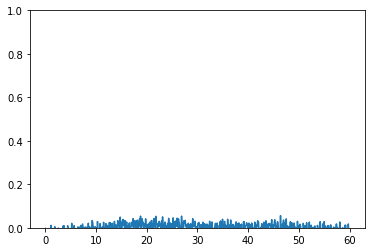

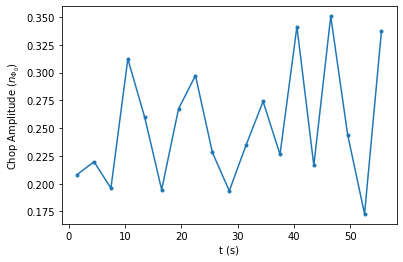

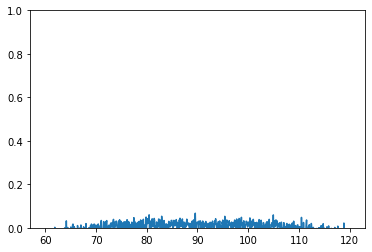

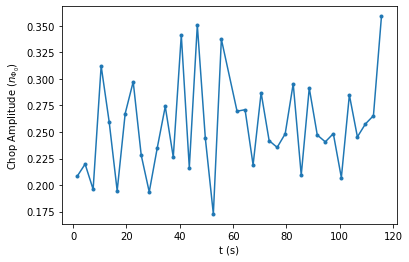

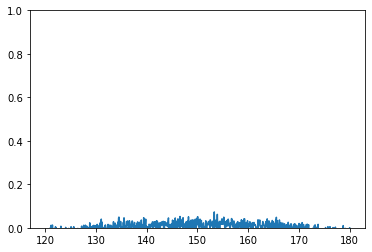

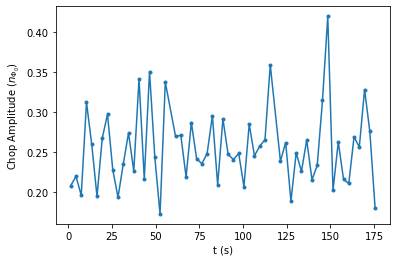

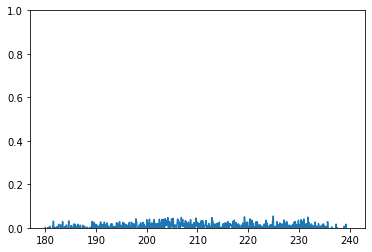

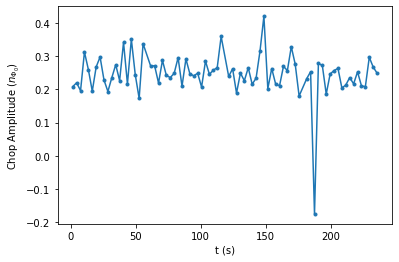

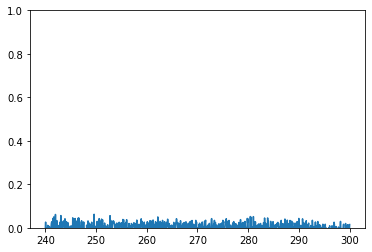

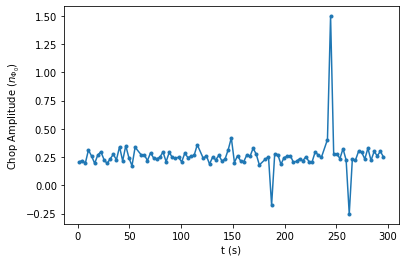

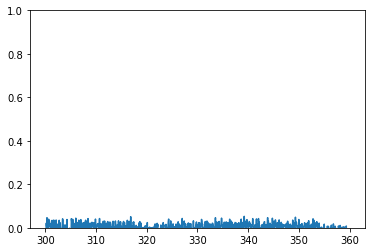

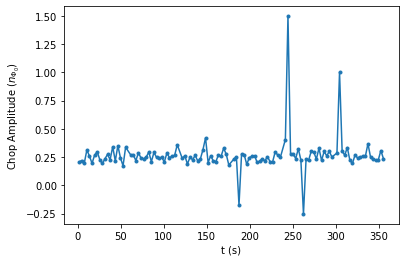

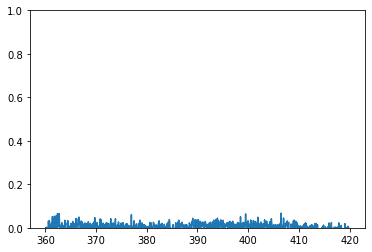

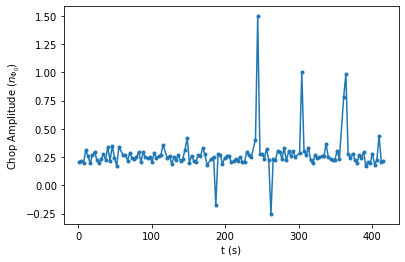

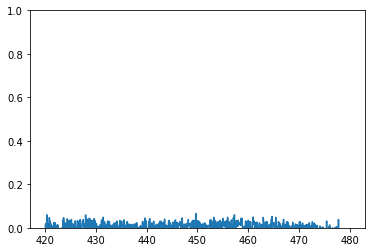

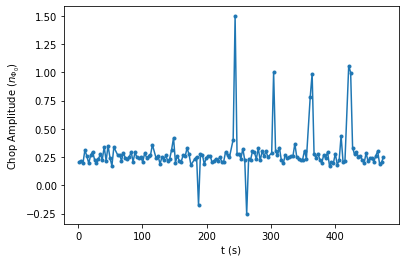

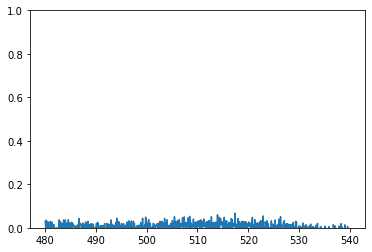

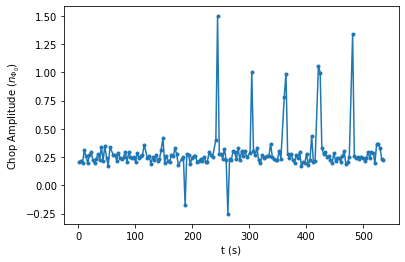

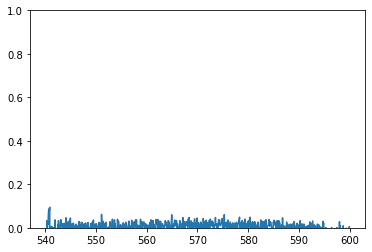

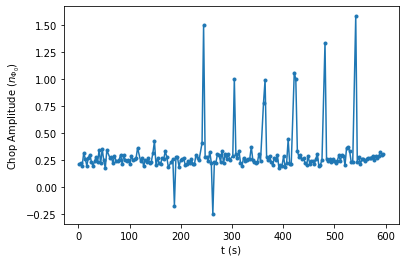

In [7]:
# testing old code polarization demod

t = test_ts_processed['fr t']
sig = test_ts_processed['fr data']
channels = [228] #np.arange(130,141,1)#range(len(test_ts_processed['demod data'])) #136,137 in LN2 set is a good chopped channel
chunks_demod = range(len(test_ts_processed['reset indices'])-2)
n_zeroed = 0
f_fr = 15 #Hz

full_demod_signal = np.array([])
full_demod_t = np.array([])

full_pol_amp_array = np.array([])
full_t_array = np.array([])

for i in tqdm(range(10)):

    start_idx = find_nearest_idx(t,60*i)
    stop_idx = find_nearest_idx(t,60*(i+1))
    
    #print(start_idx,stop_idx)
    #print(t[start_idx:stop_idx])
    
    reduced_reset_indices = test_ts_processed['reset indices'][test_ts_processed['reset indices'] <= stop_idx]
    reduced_reset_indices = reduced_reset_indices[reduced_reset_indices >= start_idx]
    
    #print(reduced_reset_indices)
    
    #print(len(t[start_idx:stop_idx]))
    
    #reset_indices = 
    
    
    n_points_no_interp = (t[-1]-t[0])*f_fr
    idx_increase_no_interp = int(n_points_no_interp)
    #endpoint_idx = find_nearest_idx(t,t[test_ts_processed['start index']] + idx_increase_no_interp*(chunk+1) - n_zeroed)
            
    
    
    chunks_demod = range(len(reduced_reset_indices)-2)
    print(chunks_demod)

    
    t_array, phase_array = demodulate(t=t[start_idx:stop_idx],
                                      sig=sig[:,start_idx:stop_idx],
                                      channels=channels,
                                      chunks=chunks_demod,
                                      n_zeroed=n_zeroed,
                                      f_fr=f_fr,
                                      time_method='original',
                                      phase_units='n_Phi0',
                                      correct_accumulated_phase=True,
                                      use_sg_filter=False,
                                      sg_degree=2,
                                      plot_demod = True,
                                      intermediate_plotting_limits = [195, 205], #s #430 440 (155,157 plots)
                                      plot_chunking_process = False,
                                      plot_fft = False,
                                      plot_limited_fft = False,
                                      plot_fit = False,
                                      plot_vectors = False,
                                      plot_phase = False,
                                      verbose = False)
    
    full_demod_signal = np.append(full_demod_signal, phase_array)
    full_demod_t = np.append(full_demod_t, t_array)
    
    f_sample = 1/3 #Hz        
    try:
        t_sampled, amplitude_array = process_polarization_data(t_array=t_array, 
                                                               phase_array = phase_array, 
                                                               f_sample = f_sample, 
                                                               plot_polarization = False, 
                                                               intermediate_plotting_limits = [125, 135], #s
                                                               plot_input = False, 
                                                               plot_chunking_process = False, 
                                                               plot_fft = False, 
                                                               plot_fft_fit = False, 
                                                               plot_limited_fft = False, 
                                                               plot_limited_fft_fit = False, 
                                                               plot_vectors = False)
    
    except:
        pass
    
    full_t_array = np.append(full_t_array, t_sampled)
    full_pol_amp_array = np.append(full_pol_amp_array, amplitude_array)
    
    fig10, ax10 = plt.subplots(1)
    
    ax10.plot(full_t_array, full_pol_amp_array,'.-')
    ax10.set_xlabel('t (s)')
    ax10.set_ylabel('Chop Amplitude ($n_{\Phi_0}$)')